# Particle Guidance synthetic experiments

We thank Bowen Jing for providing some of the code for the diffusion and distribution plotting.

## Definition of distribution and its score

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [3]:
N = 10
thetas = np.arange(N) * 2 * np.pi / N
cx = np.cos(thetas)
cy = np.sin(thetas)

In [4]:
sigma2 = 0.005
def sample():
    i = random.randint(0, N-1)
    s = np.random.multivariate_normal((cx[i], cy[i]), cov=[[sigma2, 0], [0, sigma2]])
    return s

In [4]:
samples = np.asarray([sample() for _ in range(100000)])

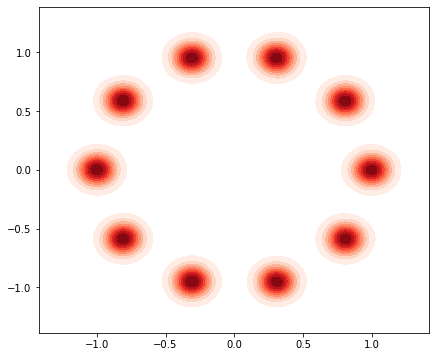

In [25]:
sns.kdeplot(x=samples[:, 0], y=samples[:, 1], cmap="Reds", shade=True, bw_adjust=.5)
plt.show()

In [5]:
import torch

def gmm(centers, X, Y, var):
    ims = [
        np.exp(-((X - x) ** 2 + (Y - y) ** 2) / var) / np.sqrt(var) for x, y in centers
    ]
    return sum(ims)


def score(centers, X, Y, var):
    weights = np.asarray([np.exp(-((X - x) ** 2 + (Y - y) ** 2) / (2 * var)) for x, y in centers])
    weights = np.array(weights) / np.sum(weights, axis=0, keepdims=True)
    scores = np.asarray([[X - x, Y - y] for x, y in centers])
    return -np.sum(np.expand_dims(weights, axis=1) * scores, axis=0) / var


score([(x,y) for x,y in zip(cx,cy)], 0.1, 1, 0.1)

array([ 0.07365016, -0.60970014])

In [ ]:
def figure_func(i, l_samples, save_name=None):
    samples = l_samples[i]
    tmp_sigma2 = sigma2 + (t_schedule[-1-i] if i<len(t_schedule) else 0)

    fig, ax = plt.subplots(1, figsize=(3, 3), dpi=150)
    x = np.linspace(-1.5, 1.5, 100)
    y = np.linspace(-1.5, 1.5, 100)

    x, y = np.meshgrid(x, y)
    im = gmm(centers, x, y, tmp_sigma2)
    ax.imshow(im, vmin=0, cmap='Reds', extent=[-1.5, 1.5, 1.5, -1.5])
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.scatter(samples[:, 0], samples[:,1], c="blue", marker='X', s=40, edgecolors="white", linewidths=0.5 )
    
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    
    if save_name is not None:
        plt.savefig(save_name)
    return fig

## Euclidean kernel particle guidance

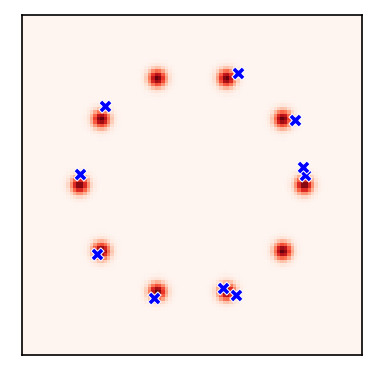

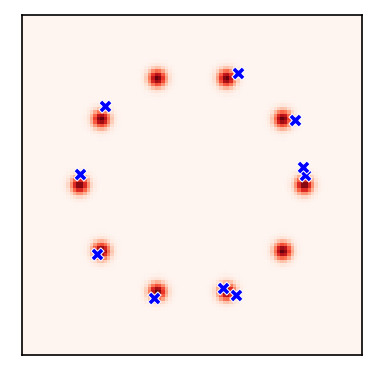

In [153]:
centers = np.asarray([(x,y) for x,y in zip(cx,cy)])
kernel_size = 0.1
svgd_repulsive_weight = 1
svgd_score_weight = 2

def particle_reverse_diffusion(N, steps=1000, max_sigma2=1, min_sigma2=0.001, 
                               svgd_score_weight=1, svgd_repulsive_weight=1, kernel_size=0.001, noise_weight=1):
    t_schedule = np.exp(np.linspace(np.log(min_sigma2), np.log(max_sigma2), steps))
    x = np.random.normal(0, np.sqrt(max_sigma2), (N, 2))
    list_samples = [x]
    
    for i in range(steps, 0, -1):
        var = t_schedule[i-1]
        d_sigma2 = t_schedule[i-1] - t_schedule[i-2] if i > 1 else t_schedule[i-1]
        score_x = score(centers, x[:, 0], x[:, 1], t_schedule[i-1] + sigma2).T
        
        diff = x[:, None] - x[None, :]
        d2_matrix = np.sum(diff*diff, axis=-1)
        #print(d2_matrix.shape)
        med2 = np.median(d2_matrix, axis=1, keepdims=True)[0]
        h = np.sqrt(var) #* med2 / max(np.log(N), 1)
        k = np.expand_dims(np.exp(-1 / h * d2_matrix), axis=-1)
        repulsive = np.sum(2 / h * diff * k, axis=1) / N #/ np.sqrt(var)
        z = np.random.normal(0, 1, (N,2))
        perturb_x = d_sigma2 * (svgd_score_weight * score_x + svgd_repulsive_weight * repulsive) + noise_weight * np.sqrt(d_sigma2) * z
        #print(score_x, repulsive)
        x = x + perturb_x
        list_samples.append(x)
        #print(x)
    
    return list_samples, t_schedule

steps = 200
particle_list_samples, t_schedule = particle_reverse_diffusion(10, steps, svgd_score_weight=1, svgd_repulsive_weight=10, kernel_size=0.001, noise_weight=1)
figure_func(-1, particle_list_samples)
#count_different_centers_wrap(svgd_score_weight=1, svgd_repulsive_weight=100, kernel_size=0.001, noise_weight=0.1, num=100)

In [66]:
def count_different_centers(x, centers):
    d = x[:, None] - centers[None, :]
    distances = np.sum(d * d, axis=-1)
    minimum = np.argmin(distances, axis=1)
    sums = np.zeros(len(centers))
    np.add.at(sums, minimum, 1)
    return np.sum(sums>0)
    
count_different_centers(particle_list_samples[-1], np.asarray(centers))

6

In [67]:
def count_different_centers_wrap(svgd_score_weight=1, svgd_repulsive_weight=1, kernel_size=0.001, noise_weight=1, num=1):
    vals = []
    for i in range(num):
        x = particle_reverse_diffusion(N=10, steps=200, svgd_score_weight=svgd_score_weight, 
                                       svgd_repulsive_weight=svgd_repulsive_weight, noise_weight=noise_weight, kernel_size=kernel_size)[0][-1]
        v = count_different_centers(x, centers)
        vals.append(v)
    print(vals)
    return sum(vals) / num

In [68]:
count_different_centers_wrap(num=10)

[7, 6, 5, 6, 7, 6, 7, 7, 6, 4]


6.1

In [54]:
possible_kernel = np.exp(np.linspace(np.log(0.01), np.log(1000), 11))
possible_noise = np.exp(np.linspace(np.log(0.01), np.log(1), 5))
possible_kernel, possible_noise

(array([1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
        1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01,
        1.00000000e+02, 3.16227766e+02, 1.00000000e+03]),
 array([0.01      , 0.03162278, 0.1       , 0.31622777, 1.        ]))

In [69]:
import tqdm 

values = [[0 for j in range(len(possible_noise))] for i in range(len(possible_kernel))]

for i in tqdm.tqdm(range(len(possible_kernel))):
    for j in range(len(possible_noise)):
        values[i][j] = count_different_centers_wrap(num=100, noise_weight=possible_noise[j], 
                                                    svgd_repulsive_weight=possible_kernel[i])


  0%|                                                    | 0/11 [00:00<?, ?it/s]

[6, 6, 7, 7, 5, 7, 7, 6, 7, 7, 6, 8, 7, 7, 7, 7, 7, 7, 5, 6, 5, 6, 7, 8, 5, 8, 6, 6, 6, 7, 6, 5, 7, 7, 7, 6, 8, 7, 8, 6, 7, 7, 7, 5, 6, 6, 6, 7, 7, 6, 8, 4, 7, 6, 6, 6, 8, 7, 6, 6, 7, 6, 7, 7, 7, 8, 7, 7, 7, 8, 6, 6, 7, 8, 6, 6, 7, 6, 6, 8, 5, 7, 7, 6, 7, 7, 6, 7, 6, 7, 8, 5, 7, 6, 6, 6, 6, 5, 7, 6]
[6, 6, 8, 7, 7, 4, 6, 8, 7, 7, 7, 5, 6, 6, 6, 8, 7, 7, 6, 6, 7, 6, 8, 7, 7, 5, 5, 6, 7, 7, 5, 7, 6, 5, 7, 5, 8, 6, 7, 6, 6, 7, 8, 6, 7, 6, 6, 7, 7, 7, 7, 7, 6, 6, 5, 5, 8, 7, 6, 7, 6, 8, 6, 5, 7, 6, 8, 5, 7, 8, 7, 8, 5, 8, 6, 5, 6, 6, 8, 6, 6, 7, 8, 8, 6, 7, 8, 8, 5, 9, 6, 6, 6, 5, 8, 7, 6, 8, 5, 7]
[6, 6, 7, 6, 6, 8, 6, 4, 6, 6, 7, 6, 5, 7, 8, 6, 8, 6, 7, 6, 7, 6, 7, 6, 6, 5, 5, 8, 7, 5, 6, 7, 6, 8, 6, 6, 8, 7, 5, 8, 7, 7, 5, 8, 7, 6, 6, 5, 7, 6, 6, 6, 6, 7, 5, 6, 7, 8, 8, 8, 6, 5, 5, 5, 6, 7, 5, 6, 7, 5, 7, 8, 8, 7, 6, 4, 8, 6, 7, 6, 6, 6, 5, 6, 7, 7, 7, 5, 6, 9, 7, 8, 8, 5, 7, 8, 6, 4, 7, 7]
[6, 6, 6, 7, 6, 8, 4, 8, 6, 6, 7, 8, 7, 7, 7, 6, 7, 6, 8, 7, 7, 7, 6, 6, 8, 6, 7, 7, 7, 6, 8, 6, 

  9%|████                                        | 1/11 [00:28<04:48, 28.89s/it]

[6, 6, 7, 7, 6, 6, 5, 6, 7, 8, 8, 6, 5, 8, 9, 7, 7, 5, 7, 6, 5, 5, 6, 6, 5, 7, 8, 6, 8, 5, 5, 6, 8, 6, 6, 7, 7, 7, 6, 5, 4, 7, 7, 5, 7, 6, 7, 5, 6, 5, 6, 8, 8, 6, 8, 6, 6, 8, 5, 7, 5, 6, 6, 6, 6, 8, 8, 8, 6, 6, 7, 7, 6, 8, 7, 6, 6, 5, 8, 6, 6, 6, 7, 6, 6, 6, 6, 6, 7, 7, 5, 5, 8, 5, 6, 6, 7, 6, 5, 7]
[7, 6, 8, 5, 6, 8, 7, 8, 7, 6, 6, 6, 6, 5, 7, 7, 5, 9, 8, 6, 9, 7, 7, 7, 5, 7, 8, 5, 8, 6, 8, 7, 8, 7, 5, 8, 7, 7, 5, 6, 7, 7, 6, 7, 6, 8, 7, 5, 6, 5, 6, 5, 8, 7, 7, 8, 7, 7, 8, 6, 8, 6, 7, 6, 7, 8, 6, 7, 5, 6, 7, 8, 7, 6, 7, 8, 8, 7, 6, 5, 6, 5, 8, 6, 6, 6, 6, 6, 6, 7, 7, 5, 8, 7, 6, 6, 7, 6, 5, 5]
[8, 6, 8, 5, 8, 5, 6, 6, 6, 7, 5, 7, 6, 8, 7, 5, 7, 7, 5, 6, 8, 7, 8, 6, 5, 8, 7, 7, 6, 5, 7, 7, 5, 7, 7, 5, 7, 5, 5, 7, 8, 6, 8, 8, 5, 7, 6, 9, 6, 6, 5, 5, 5, 7, 7, 7, 8, 7, 5, 6, 5, 7, 7, 5, 6, 5, 5, 9, 6, 7, 7, 8, 6, 7, 6, 7, 6, 7, 7, 7, 5, 7, 6, 5, 7, 9, 5, 6, 7, 7, 6, 7, 6, 7, 7, 9, 7, 8, 7, 7]
[7, 8, 7, 6, 7, 6, 9, 7, 5, 6, 6, 7, 5, 7, 6, 8, 6, 7, 8, 6, 6, 6, 6, 6, 8, 7, 4, 8, 8, 6, 7, 6, 

 18%|████████                                    | 2/11 [00:57<04:20, 28.89s/it]

[6, 6, 8, 7, 7, 6, 7, 6, 6, 8, 7, 6, 7, 7, 7, 8, 7, 7, 7, 6, 6, 7, 7, 8, 8, 6, 8, 8, 6, 6, 5, 8, 8, 5, 6, 5, 7, 5, 7, 7, 6, 8, 4, 6, 7, 7, 7, 6, 6, 8, 7, 5, 7, 6, 6, 7, 6, 7, 5, 6, 6, 6, 5, 5, 5, 5, 8, 6, 5, 6, 6, 7, 8, 7, 7, 7, 7, 8, 6, 7, 5, 7, 8, 5, 7, 9, 5, 7, 6, 5, 5, 8, 6, 7, 6, 8, 6, 6, 6, 7]
[6, 5, 6, 9, 7, 7, 7, 7, 7, 5, 5, 8, 6, 5, 6, 6, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 5, 5, 7, 7, 6, 6, 6, 7, 7, 7, 7, 6, 6, 7, 7, 4, 6, 8, 6, 7, 7, 6, 7, 8, 7, 5, 6, 6, 7, 6, 6, 6, 7, 6, 6, 8, 5, 6, 8, 6, 8, 7, 7, 8, 6, 8, 7, 4, 6, 6, 6, 6, 6, 5, 8, 7, 8, 6, 6, 6, 6, 7, 6, 6, 7, 7, 9, 6, 5, 7, 7, 7, 7, 6]
[7, 8, 6, 6, 8, 7, 7, 7, 7, 7, 5, 7, 7, 6, 6, 6, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 5, 8, 5, 7, 7, 7, 6, 6, 7, 7, 7, 5, 5, 5, 6, 6, 8, 6, 7, 5, 6, 7, 7, 6, 9, 6, 5, 5, 6, 4, 6, 7, 7, 8, 4, 7, 7, 5, 7, 6, 6, 7, 5, 7, 8, 7, 6, 8, 7, 6, 6, 7, 6, 6, 6, 8, 6, 6, 7, 6, 6, 7, 6, 6, 7, 5, 6, 7, 8, 7, 7, 6, 6]
[7, 8, 7, 6, 7, 7, 5, 8, 6, 7, 7, 6, 6, 7, 7, 7, 7, 6, 7, 7, 8, 7, 6, 6, 6, 7, 8, 5, 8, 8, 6, 6, 

 27%|████████████                                | 3/11 [01:26<03:51, 28.88s/it]

[7, 7, 6, 6, 7, 7, 6, 7, 8, 8, 6, 6, 7, 7, 7, 7, 7, 6, 8, 8, 9, 5, 6, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 6, 7, 7, 7, 6, 7, 8, 5, 7, 8, 7, 7, 9, 9, 6, 8, 6, 7, 4, 6, 7, 6, 7, 6, 7, 8, 6, 6, 7, 7, 7, 7, 5, 5, 6, 8, 7, 6, 7, 6, 7, 8, 7, 8, 6, 7, 6, 5, 6, 6, 7, 6, 6, 7, 8, 8, 6, 6, 7, 7, 7, 7, 6, 8]
[9, 8, 5, 6, 8, 7, 6, 8, 6, 7, 7, 4, 7, 8, 7, 6, 6, 6, 8, 8, 6, 8, 7, 6, 8, 7, 6, 9, 7, 8, 7, 7, 7, 7, 6, 8, 7, 6, 8, 6, 7, 7, 7, 6, 8, 6, 7, 6, 6, 6, 5, 7, 9, 8, 6, 7, 7, 7, 7, 6, 7, 8, 5, 8, 8, 5, 5, 8, 7, 5, 6, 6, 9, 7, 6, 6, 6, 6, 9, 7, 6, 7, 8, 8, 6, 6, 9, 7, 7, 6, 6, 7, 7, 6, 6, 6, 7, 7, 7, 5]
[7, 7, 7, 4, 6, 7, 8, 7, 7, 5, 7, 7, 7, 6, 8, 6, 8, 7, 6, 6, 7, 7, 5, 6, 6, 6, 8, 4, 6, 6, 5, 8, 7, 8, 6, 7, 5, 7, 9, 6, 8, 7, 9, 7, 9, 6, 7, 5, 8, 7, 7, 9, 7, 9, 5, 7, 7, 6, 8, 5, 8, 8, 6, 7, 8, 7, 7, 6, 8, 7, 7, 8, 7, 7, 6, 7, 7, 7, 8, 6, 7, 7, 8, 7, 6, 8, 5, 6, 7, 5, 6, 8, 5, 7, 8, 6, 7, 9, 7, 6]
[7, 8, 6, 7, 7, 5, 7, 6, 5, 5, 8, 6, 7, 6, 7, 6, 7, 6, 7, 6, 6, 6, 6, 5, 8, 7, 7, 4, 8, 7, 6, 6, 

 36%|████████████████                            | 4/11 [01:55<03:22, 28.94s/it]

[6, 7, 8, 6, 6, 8, 6, 8, 7, 8, 7, 5, 7, 7, 6, 6, 7, 7, 7, 6, 6, 7, 8, 8, 6, 8, 7, 9, 7, 7, 7, 6, 7, 5, 8, 5, 6, 7, 6, 7, 5, 5, 8, 7, 7, 5, 7, 7, 7, 6, 7, 5, 7, 4, 7, 7, 6, 5, 7, 7, 6, 6, 8, 6, 8, 7, 6, 5, 8, 9, 8, 6, 7, 6, 8, 8, 5, 7, 6, 6, 6, 7, 6, 6, 7, 6, 6, 6, 5, 6, 7, 7, 8, 6, 7, 5, 6, 8, 6, 8]
[8, 7, 8, 8, 6, 6, 6, 7, 6, 9, 7, 7, 8, 7, 8, 7, 9, 7, 9, 6, 6, 7, 8, 7, 6, 7, 7, 5, 6, 7, 5, 5, 9, 7, 8, 9, 8, 8, 6, 7, 8, 7, 7, 6, 7, 8, 8, 7, 8, 5, 8, 7, 8, 6, 6, 6, 8, 7, 7, 7, 8, 6, 6, 7, 6, 9, 7, 6, 8, 8, 7, 8, 5, 6, 7, 7, 8, 8, 7, 8, 8, 8, 7, 8, 8, 9, 7, 7, 8, 7, 7, 9, 7, 8, 7, 7, 8, 7, 6, 7]
[7, 7, 7, 6, 7, 7, 8, 7, 8, 6, 9, 6, 6, 7, 5, 7, 8, 7, 7, 7, 7, 8, 6, 7, 9, 7, 8, 6, 7, 6, 7, 7, 7, 8, 7, 7, 6, 7, 6, 5, 7, 8, 7, 6, 6, 7, 7, 8, 9, 8, 7, 7, 8, 7, 6, 6, 7, 7, 8, 8, 8, 8, 8, 6, 8, 9, 7, 7, 6, 8, 7, 7, 8, 7, 7, 7, 6, 7, 6, 7, 6, 8, 7, 7, 7, 7, 8, 9, 6, 9, 6, 7, 6, 7, 6, 9, 8, 7, 8, 8]
[7, 6, 8, 8, 9, 8, 9, 7, 6, 8, 7, 9, 5, 8, 6, 6, 7, 8, 7, 7, 7, 7, 8, 8, 8, 7, 8, 6, 7, 7, 7, 7, 

 45%|████████████████████                        | 5/11 [02:24<02:53, 28.89s/it]

[7, 7, 7, 7, 6, 7, 8, 8, 8, 6, 5, 8, 8, 8, 6, 6, 8, 7, 7, 6, 6, 7, 8, 7, 6, 7, 6, 7, 8, 7, 5, 6, 6, 6, 6, 7, 8, 6, 7, 6, 6, 5, 6, 6, 7, 6, 5, 7, 5, 8, 7, 8, 6, 8, 7, 8, 7, 6, 6, 5, 5, 6, 6, 7, 7, 8, 5, 7, 7, 5, 8, 7, 7, 7, 7, 7, 6, 7, 6, 8, 8, 6, 8, 6, 7, 8, 6, 6, 6, 5, 6, 7, 5, 7, 6, 5, 5, 6, 6, 5]
[8, 8, 8, 8, 9, 9, 8, 8, 8, 8, 9, 8, 8, 9, 8, 8, 8, 8, 7, 7, 7, 8, 8, 8, 7, 8, 7, 8, 8, 7, 8, 7, 8, 8, 7, 8, 7, 9, 8, 9, 8, 7, 8, 9, 8, 9, 8, 9, 6, 8, 8, 8, 8, 7, 7, 7, 8, 9, 7, 8, 8, 9, 8, 8, 8, 9, 9, 9, 8, 8, 7, 6, 7, 9, 7, 6, 8, 8, 7, 8, 8, 9, 8, 7, 8, 8, 8, 6, 9, 7, 7, 8, 8, 9, 8, 9, 9, 8, 8, 7]
[8, 9, 7, 6, 8, 7, 7, 9, 8, 9, 7, 8, 6, 8, 9, 7, 8, 7, 8, 8, 7, 8, 8, 8, 8, 6, 8, 9, 8, 7, 8, 8, 9, 7, 8, 9, 9, 6, 8, 7, 7, 8, 9, 8, 9, 7, 10, 8, 7, 9, 8, 9, 9, 8, 8, 9, 8, 9, 8, 7, 9, 7, 9, 8, 8, 7, 9, 9, 6, 9, 7, 9, 8, 8, 8, 8, 7, 8, 8, 8, 7, 8, 8, 7, 7, 8, 9, 8, 7, 8, 9, 7, 7, 8, 9, 8, 8, 9, 9, 9]
[9, 8, 8, 7, 7, 9, 8, 10, 9, 7, 8, 8, 8, 8, 8, 9, 6, 9, 7, 8, 7, 10, 7, 8, 6, 6, 7, 8, 9, 9, 8, 

 55%|████████████████████████                    | 6/11 [02:53<02:24, 28.86s/it]

[7, 7, 7, 6, 7, 6, 7, 10, 7, 7, 6, 4, 9, 7, 7, 8, 7, 8, 7, 6, 8, 8, 8, 6, 7, 8, 7, 8, 6, 6, 5, 7, 6, 7, 8, 9, 6, 8, 6, 7, 8, 8, 6, 8, 8, 8, 5, 6, 7, 7, 8, 6, 5, 6, 8, 7, 8, 7, 6, 5, 9, 7, 6, 6, 6, 6, 6, 8, 7, 7, 7, 7, 8, 6, 7, 7, 6, 6, 6, 8, 6, 7, 7, 4, 7, 8, 7, 8, 7, 5, 9, 8, 8, 7, 6, 7, 8, 7, 8, 5]
[9, 9, 8, 9, 8, 9, 9, 9, 9, 10, 8, 8, 8, 8, 9, 9, 9, 7, 9, 7, 9, 8, 9, 9, 8, 8, 9, 9, 8, 8, 10, 9, 9, 9, 7, 9, 9, 10, 9, 8, 8, 9, 10, 8, 9, 8, 8, 8, 9, 8, 8, 10, 7, 9, 9, 7, 8, 8, 8, 9, 9, 8, 8, 9, 8, 8, 9, 8, 9, 8, 8, 9, 9, 8, 9, 8, 9, 8, 8, 9, 9, 8, 10, 9, 8, 9, 8, 9, 9, 8, 9, 9, 8, 10, 10, 9, 9, 8, 8, 8]
[9, 10, 9, 9, 8, 9, 8, 9, 9, 8, 8, 9, 9, 8, 8, 8, 7, 9, 9, 9, 10, 10, 8, 9, 9, 9, 9, 8, 8, 9, 9, 8, 8, 9, 8, 9, 9, 8, 7, 9, 8, 7, 9, 8, 8, 8, 9, 7, 9, 9, 8, 8, 8, 8, 9, 9, 8, 9, 9, 8, 8, 9, 8, 8, 8, 9, 9, 8, 9, 9, 8, 9, 9, 9, 9, 8, 9, 8, 9, 9, 8, 9, 9, 9, 9, 8, 8, 9, 7, 8, 10, 9, 7, 8, 8, 9, 9, 8, 7, 9]
[10, 8, 9, 9, 9, 9, 9, 8, 8, 9, 8, 8, 8, 9, 8, 8, 9, 7, 9, 9, 8, 10, 9, 9, 9, 8, 9, 

 64%|████████████████████████████                | 7/11 [03:21<01:55, 28.80s/it]

[7, 8, 8, 7, 9, 7, 7, 8, 8, 7, 8, 8, 8, 8, 8, 8, 9, 7, 7, 8, 8, 7, 7, 6, 7, 7, 7, 8, 7, 9, 8, 9, 9, 8, 7, 8, 6, 9, 7, 7, 8, 7, 8, 9, 8, 8, 7, 7, 8, 7, 7, 7, 8, 7, 7, 7, 10, 7, 9, 9, 9, 6, 6, 7, 8, 8, 8, 8, 7, 8, 8, 9, 6, 8, 8, 8, 7, 8, 7, 9, 7, 7, 8, 7, 9, 7, 9, 8, 8, 6, 8, 7, 7, 8, 6, 9, 7, 7, 8, 8]
[9, 8, 8, 9, 9, 9, 9, 8, 7, 8, 8, 8, 8, 8, 8, 10, 8, 9, 7, 8, 10, 10, 9, 10, 8, 8, 9, 8, 8, 10, 8, 8, 9, 10, 8, 8, 9, 8, 9, 8, 9, 9, 8, 9, 8, 8, 8, 9, 9, 9, 10, 8, 9, 9, 9, 8, 8, 9, 8, 9, 9, 9, 8, 8, 9, 7, 8, 8, 8, 9, 9, 7, 9, 7, 7, 9, 8, 8, 8, 8, 9, 8, 9, 8, 9, 9, 8, 10, 8, 8, 10, 9, 9, 9, 9, 9, 10, 8, 9, 8]
[9, 10, 9, 9, 9, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 9, 9, 8, 10, 9, 9, 8, 9, 10, 9, 9, 10, 8, 8, 8, 9, 8, 9, 9, 8, 8, 9, 7, 9, 9, 9, 8, 9, 9, 9, 10, 9, 9, 9, 8, 9, 9, 8, 9, 8, 9, 10, 8, 9, 9, 9, 8, 9, 8, 8, 9, 10, 10, 9, 8, 8, 10, 9, 9, 9, 8, 9, 9, 9, 9, 9, 10, 9, 10, 9, 9, 9, 8, 9, 8, 8, 9, 9, 9, 9, 10, 8, 10, 8]
[9, 9, 9, 9, 9, 9, 9, 8, 9, 9, 9, 8, 9, 9, 10, 10, 8, 8, 8, 8, 8, 9, 10, 

 73%|████████████████████████████████            | 8/11 [03:50<01:26, 28.74s/it]

[8, 7, 8, 8, 8, 8, 9, 8, 10, 9, 9, 9, 8, 9, 7, 9, 9, 9, 8, 7, 8, 9, 8, 9, 8, 7, 7, 8, 8, 9, 8, 7, 7, 9, 8, 9, 7, 9, 7, 10, 9, 9, 7, 9, 9, 9, 8, 7, 8, 8, 10, 9, 8, 8, 8, 9, 8, 8, 9, 8, 9, 9, 7, 8, 8, 9, 8, 9, 8, 7, 9, 7, 8, 7, 8, 7, 7, 8, 7, 7, 7, 9, 8, 9, 7, 9, 9, 8, 7, 7, 7, 8, 8, 8, 9, 9, 8, 8, 8, 8]
[8, 9, 9, 9, 9, 9, 10, 7, 7, 9, 9, 9, 10, 9, 9, 9, 9, 9, 9, 10, 10, 9, 8, 9, 9, 9, 9, 10, 9, 9, 8, 9, 9, 9, 9, 10, 8, 8, 8, 8, 9, 9, 8, 8, 7, 8, 10, 9, 9, 9, 9, 9, 8, 9, 9, 8, 8, 8, 9, 8, 9, 9, 8, 9, 9, 8, 10, 9, 9, 9, 8, 10, 8, 8, 9, 9, 9, 9, 9, 9, 8, 8, 10, 9, 9, 9, 9, 8, 9, 9, 8, 9, 9, 9, 9, 8, 10, 8, 8, 9]
[9, 10, 8, 7, 8, 8, 9, 9, 10, 8, 10, 9, 9, 9, 9, 9, 8, 9, 9, 10, 10, 8, 9, 7, 9, 9, 9, 8, 9, 8, 8, 8, 10, 10, 8, 9, 8, 8, 8, 10, 9, 9, 9, 9, 9, 9, 8, 9, 8, 10, 10, 10, 7, 10, 8, 9, 10, 10, 9, 8, 9, 8, 8, 9, 8, 9, 8, 9, 9, 8, 9, 9, 8, 8, 8, 9, 7, 8, 8, 9, 8, 9, 8, 10, 10, 10, 10, 9, 10, 8, 7, 9, 9, 10, 9, 9, 8, 9, 9, 8]
[8, 9, 8, 8, 9, 9, 9, 9, 9, 8, 10, 9, 8, 9, 9, 8, 9, 9, 7, 10, 

 82%|████████████████████████████████████        | 9/11 [04:19<00:57, 28.70s/it]

[9, 9, 8, 8, 7, 9, 9, 9, 8, 9, 8, 8, 7, 9, 9, 8, 8, 8, 8, 7, 8, 7, 9, 10, 9, 9, 8, 9, 8, 9, 8, 8, 8, 8, 8, 9, 8, 8, 9, 9, 7, 8, 9, 9, 9, 8, 8, 8, 9, 10, 9, 8, 8, 9, 8, 9, 9, 9, 8, 9, 8, 9, 8, 9, 8, 10, 7, 8, 9, 9, 7, 9, 9, 9, 9, 7, 9, 8, 8, 9, 8, 9, 9, 8, 7, 9, 9, 8, 9, 9, 9, 8, 8, 8, 8, 10, 8, 9, 8, 10]
[9, 10, 9, 9, 9, 10, 8, 8, 9, 7, 9, 10, 10, 9, 10, 9, 9, 9, 7, 10, 9, 9, 8, 8, 9, 9, 10, 8, 9, 7, 8, 10, 9, 8, 9, 9, 7, 9, 9, 8, 8, 8, 8, 8, 8, 8, 9, 9, 8, 8, 8, 8, 8, 9, 9, 9, 8, 8, 9, 9, 9, 7, 10, 9, 8, 10, 10, 10, 8, 9, 10, 9, 10, 10, 9, 9, 8, 9, 9, 8, 7, 8, 8, 8, 8, 8, 9, 8, 10, 8, 8, 10, 9, 9, 8, 8, 10, 8, 10, 10]
[10, 10, 10, 9, 9, 9, 9, 8, 10, 10, 9, 10, 8, 9, 10, 8, 8, 9, 9, 8, 10, 9, 8, 8, 8, 10, 10, 7, 8, 9, 8, 10, 9, 9, 10, 9, 9, 9, 10, 9, 10, 9, 10, 9, 9, 10, 10, 9, 8, 8, 9, 9, 8, 8, 8, 9, 9, 7, 8, 8, 9, 9, 8, 9, 9, 8, 8, 10, 9, 7, 9, 9, 10, 9, 9, 9, 9, 9, 8, 8, 9, 8, 9, 10, 9, 9, 8, 10, 9, 10, 10, 9, 10, 9, 8, 8, 9, 10, 9, 8]
[9, 8, 10, 9, 9, 7, 9, 9, 9, 10, 9, 8, 8, 8, 8,

 91%|███████████████████████████████████████    | 10/11 [04:47<00:28, 28.68s/it]

[9, 8, 8, 8, 8, 9, 8, 8, 9, 8, 8, 8, 7, 9, 9, 8, 8, 9, 8, 9, 9, 8, 10, 9, 8, 8, 9, 9, 9, 9, 9, 8, 8, 9, 8, 9, 8, 8, 8, 9, 8, 8, 8, 9, 9, 7, 10, 8, 8, 8, 8, 10, 8, 8, 9, 9, 8, 9, 9, 9, 9, 8, 9, 9, 9, 9, 8, 8, 9, 8, 9, 9, 9, 10, 9, 9, 7, 7, 8, 10, 8, 9, 9, 8, 9, 8, 10, 8, 9, 10, 8, 8, 8, 10, 10, 8, 10, 8, 8, 8]
[8, 9, 10, 9, 9, 8, 9, 8, 9, 8, 8, 10, 8, 8, 9, 9, 8, 8, 9, 8, 8, 8, 7, 9, 8, 9, 9, 10, 9, 8, 8, 10, 8, 10, 9, 8, 8, 9, 9, 8, 8, 9, 8, 9, 10, 8, 9, 9, 8, 8, 9, 8, 8, 8, 8, 8, 8, 9, 9, 9, 10, 9, 7, 9, 9, 9, 9, 9, 10, 9, 9, 9, 9, 8, 9, 10, 8, 8, 9, 8, 7, 9, 9, 9, 9, 9, 8, 9, 8, 10, 7, 8, 8, 9, 9, 10, 9, 9, 9, 9]
[10, 9, 8, 9, 8, 9, 9, 8, 9, 8, 10, 8, 10, 7, 10, 10, 8, 9, 9, 9, 8, 9, 9, 9, 9, 8, 7, 9, 9, 9, 8, 10, 10, 8, 8, 9, 9, 9, 9, 8, 9, 8, 8, 10, 10, 7, 8, 10, 8, 9, 9, 9, 8, 9, 9, 8, 8, 9, 7, 10, 8, 8, 8, 9, 10, 8, 10, 10, 10, 9, 10, 8, 9, 9, 9, 8, 9, 10, 7, 9, 8, 9, 9, 7, 10, 10, 9, 10, 9, 9, 9, 8, 10, 8, 8, 8, 8, 8, 9, 9]
[9, 9, 7, 8, 9, 8, 9, 9, 10, 7, 7, 9, 9, 9, 10, 8, 7, 9

100%|███████████████████████████████████████████| 11/11 [05:16<00:00, 28.77s/it]

[10, 8, 8, 9, 9, 10, 10, 10, 9, 9, 9, 10, 8, 9, 9, 9, 8, 8, 9, 8, 8, 10, 8, 8, 9, 10, 8, 8, 10, 9, 9, 10, 8, 9, 9, 8, 7, 8, 10, 9, 9, 9, 9, 8, 8, 8, 9, 10, 8, 9, 9, 9, 8, 8, 9, 9, 8, 8, 8, 9, 9, 9, 8, 10, 8, 8, 8, 9, 9, 9, 8, 8, 9, 9, 8, 8, 9, 9, 9, 9, 8, 9, 10, 9, 10, 9, 9, 9, 9, 10, 9, 9, 9, 10, 9, 8, 7, 9, 8, 8]


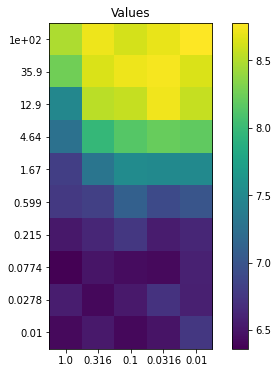

In [18]:
import matplotlib.pyplot as plt
values_reversed = list(reversed([list(reversed(v)) for v in values]))

plt.rcParams["figure.figsize"] = (7,6)
fig, ax = plt.subplots()
im = ax.imshow(values_reversed)

# Add colorbar
ax.set_xticks(np.arange(len(possible_noise)), labels = [f'{s:.3}' for s in list(reversed(possible_noise))])
ax.set_yticks(np.arange(len(possible_kernel)), labels=[f'{s:.3}' for s in list(reversed(possible_kernel))])
ax.figure.colorbar(im, ax=ax)

plt.title("Values")
plt.show()

## Radial kernel particle guidance

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


10.0

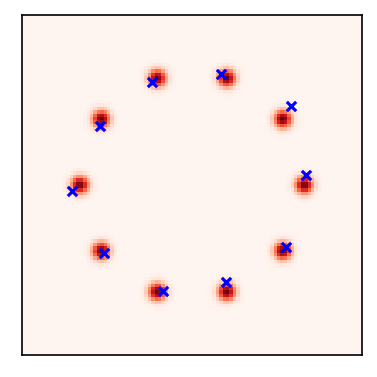

In [135]:
centers = np.asarray([(x,y) for x,y in zip(cx,cy)])

def radial_particle_reverse_diffusion(N, steps=1000, max_sigma2=1, min_sigma2=0.001, 
                               svgd_score_weight=2, svgd_repulsive_weight=100, kernel_size=0.001, noise_weight=1):
    t_schedule = np.exp(np.linspace(np.log(min_sigma2), np.log(max_sigma2), steps))
    x = np.random.normal(0, np.sqrt(max_sigma2), (N, 2))
    list_samples = [x]
    
    for i in range(steps, 0, -1):
        var = t_schedule[i-1]
        d_sigma2 = t_schedule[i-1] - t_schedule[i-2] if i > 1 else t_schedule[i-1]
        score_x = score(centers, x[:, 0], x[:, 1], t_schedule[i-1] + sigma2).T
        
        rad = np.angle(x[:, 0] + 1j* x[:, 1])
        diff = np.mod(rad[:, None] - rad[None, :] + 3 * np.pi, 2 * np.pi) - np.pi
        #print(diff)
        d2_matrix = diff*diff
        #print(d2_matrix.shape)
        #med2 = np.median(d2_matrix, axis=1, keepdims=True)[0]
        h = np.pi * np.sqrt(var) #* med2 / max(np.log(N), 1)
        k = np.exp(-1 / h * d2_matrix)
        
        
        repulsive = np.sum(2 / h * diff * k, axis=1) / N #/ np.sqrt(var)
        z = np.random.normal(0, 1, (N,2))
        perturb_x = d_sigma2 * svgd_score_weight * score_x + noise_weight * np.sqrt(d_sigma2) * z
        #print(score_x, repulsive)
        rot_angle = repulsive * d_sigma2 * svgd_repulsive_weight
        rot_mat = np.moveaxis(np.asarray([[np.cos(rot_angle), -np.sin(rot_angle)], [np.sin(rot_angle), np.cos(rot_angle)]]), -1, 0)
        #print(rot_angle.shape, score_x.shape, rot_mat.shape)
        x = np.einsum('ijk,ik->ij', rot_mat, x)
        x = x + perturb_x
        list_samples.append(x)
        #print(x)
    
    return list_samples, t_schedule

steps = 200
radial_particle_list_samples, t_schedule = radial_particle_reverse_diffusion(10, steps, svgd_score_weight=1, svgd_repulsive_weight=1000, kernel_size=0.001, noise_weight=1)
list_samples, t_schedule = radial_particle_reverse_diffusion(10, steps, svgd_score_weight=1, svgd_repulsive_weight=0, kernel_size=0.001, noise_weight=1)
figure_func(-1, radial_particle_list_samples)
radial_count_different_centers_wrap(svgd_score_weight=1, svgd_repulsive_weight=1000, kernel_size=0.001, noise_weight=0.1, num=100)

In [45]:
def radial_count_different_centers_wrap(svgd_score_weight=1, svgd_repulsive_weight=1, kernel_size=0.001, noise_weight=1, num=1):
    vals = []
    for i in range(num):
        x = radial_particle_reverse_diffusion(N=10, steps=200, svgd_score_weight=svgd_score_weight, 
                                       svgd_repulsive_weight=svgd_repulsive_weight, noise_weight=noise_weight, kernel_size=kernel_size)[0][-1]
        v = count_different_centers(x, centers)
        vals.append(v)
    print(vals)
    return sum(vals) / num

In [57]:
import tqdm 

radial_values = [[0 for j in range(len(possible_noise))] for i in range(len(possible_kernel))]
for i in tqdm.tqdm(range(len(possible_kernel))):
    for j in range(len(possible_noise)):
        radial_values[i][j] = radial_count_different_centers_wrap(num=100, noise_weight=possible_noise[j], 
                                                    svgd_repulsive_weight=possible_kernel[i])


  0%|                                                    | 0/11 [00:00<?, ?it/s]

[5, 7, 6, 8, 7, 6, 5, 7, 6, 5, 8, 6, 8, 7, 6, 7, 6, 7, 6, 8, 8, 5, 6, 7, 7, 7, 4, 7, 7, 6, 5, 7, 7, 6, 6, 7, 6, 6, 7, 7, 6, 8, 7, 8, 7, 5, 7, 6, 6, 6, 7, 6, 6, 7, 6, 5, 4, 7, 7, 7, 6, 6, 6, 8, 6, 7, 6, 7, 6, 8, 5, 7, 7, 7, 5, 8, 6, 6, 6, 7, 6, 4, 7, 5, 7, 5, 8, 6, 6, 5, 6, 8, 6, 6, 5, 6, 6, 6, 6, 8]
[5, 6, 6, 7, 7, 8, 6, 6, 5, 7, 5, 7, 7, 7, 5, 8, 8, 8, 6, 5, 6, 8, 7, 7, 6, 6, 5, 7, 8, 6, 6, 8, 6, 7, 6, 6, 5, 9, 6, 7, 6, 5, 5, 7, 3, 6, 5, 7, 7, 7, 5, 7, 8, 7, 5, 6, 4, 4, 7, 7, 6, 8, 6, 6, 7, 6, 6, 7, 6, 7, 8, 6, 6, 8, 7, 7, 6, 6, 6, 7, 7, 5, 7, 9, 7, 7, 6, 6, 6, 7, 7, 6, 5, 6, 7, 7, 7, 6, 5, 8]
[8, 4, 8, 5, 6, 8, 7, 6, 7, 8, 7, 7, 6, 6, 7, 7, 6, 8, 5, 7, 6, 6, 7, 8, 5, 6, 6, 6, 7, 8, 7, 7, 6, 7, 7, 6, 7, 6, 6, 6, 5, 7, 5, 7, 7, 6, 6, 8, 8, 7, 5, 8, 7, 7, 7, 6, 6, 8, 7, 6, 8, 8, 7, 6, 7, 6, 8, 5, 5, 6, 7, 7, 6, 5, 7, 7, 8, 6, 8, 7, 6, 7, 5, 7, 5, 6, 5, 6, 6, 6, 5, 6, 7, 7, 9, 7, 6, 5, 7, 6]
[6, 7, 7, 7, 4, 7, 6, 8, 7, 5, 7, 6, 6, 7, 7, 7, 6, 7, 8, 5, 5, 7, 6, 6, 8, 7, 7, 8, 6, 7, 7, 6, 

  9%|████                                        | 1/11 [00:27<04:30, 27.10s/it]

[6, 7, 7, 7, 6, 6, 7, 6, 6, 7, 7, 6, 6, 8, 7, 7, 5, 7, 8, 8, 6, 5, 7, 7, 6, 5, 8, 6, 6, 6, 5, 7, 7, 7, 6, 6, 6, 7, 6, 7, 7, 5, 8, 6, 6, 5, 5, 5, 6, 6, 6, 7, 5, 6, 7, 7, 6, 7, 6, 5, 6, 6, 5, 8, 6, 7, 6, 6, 4, 6, 7, 7, 6, 6, 5, 7, 6, 8, 6, 6, 6, 5, 6, 6, 7, 8, 6, 7, 5, 6, 7, 7, 5, 7, 7, 4, 8, 4, 5, 6]
[5, 5, 7, 7, 6, 6, 6, 7, 7, 6, 6, 9, 8, 6, 6, 7, 6, 7, 4, 7, 7, 7, 7, 6, 6, 7, 8, 7, 6, 5, 5, 7, 7, 7, 6, 6, 8, 5, 6, 7, 6, 6, 6, 7, 7, 6, 9, 5, 8, 6, 7, 6, 7, 5, 8, 9, 7, 7, 7, 7, 5, 6, 6, 9, 8, 6, 7, 6, 5, 7, 6, 6, 8, 7, 5, 8, 6, 6, 6, 7, 7, 6, 5, 8, 6, 7, 7, 4, 6, 6, 6, 6, 6, 6, 7, 9, 8, 7, 5, 8]
[7, 8, 6, 6, 7, 7, 7, 7, 5, 7, 6, 6, 5, 7, 7, 7, 6, 6, 7, 5, 7, 5, 7, 6, 8, 6, 8, 6, 5, 7, 7, 7, 7, 6, 7, 6, 7, 7, 6, 7, 7, 7, 5, 6, 7, 8, 7, 6, 7, 5, 6, 7, 7, 5, 6, 8, 7, 5, 7, 8, 7, 8, 7, 6, 4, 6, 8, 6, 7, 8, 8, 8, 6, 5, 7, 6, 6, 7, 5, 7, 6, 4, 5, 6, 8, 7, 6, 8, 6, 6, 8, 6, 5, 9, 6, 7, 7, 6, 6, 5]
[8, 8, 6, 6, 7, 8, 7, 6, 7, 8, 8, 5, 6, 7, 8, 6, 7, 7, 8, 7, 5, 6, 6, 7, 7, 8, 6, 6, 7, 6, 6, 7, 

 18%|████████                                    | 2/11 [00:54<04:04, 27.17s/it]

[8, 6, 6, 6, 7, 6, 7, 6, 7, 7, 5, 8, 7, 8, 4, 6, 6, 6, 6, 6, 5, 6, 7, 5, 6, 5, 6, 7, 6, 7, 7, 6, 8, 8, 7, 8, 8, 6, 5, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 8, 6, 6, 5, 7, 6, 5, 7, 7, 8, 6, 7, 5, 6, 6, 6, 7, 6, 5, 7, 7, 6, 6, 5, 7, 6, 7, 6, 6, 6, 5, 5, 8, 5, 7, 8, 8, 6, 6, 6, 8, 7, 5, 7, 7, 7, 7, 7, 7, 8]
[5, 7, 8, 6, 7, 7, 7, 7, 6, 7, 6, 6, 6, 6, 6, 8, 6, 7, 6, 6, 7, 6, 8, 6, 8, 7, 4, 7, 7, 6, 5, 6, 6, 7, 6, 7, 5, 5, 6, 7, 7, 6, 6, 6, 6, 5, 5, 7, 6, 6, 6, 5, 8, 8, 8, 7, 7, 6, 7, 5, 5, 5, 9, 7, 6, 8, 7, 5, 7, 7, 5, 7, 6, 7, 7, 7, 7, 6, 5, 6, 7, 6, 6, 6, 7, 8, 8, 5, 5, 6, 8, 6, 7, 6, 7, 6, 6, 8, 5, 6]
[6, 7, 6, 6, 7, 7, 7, 6, 8, 6, 7, 5, 6, 7, 6, 9, 8, 6, 6, 8, 7, 7, 5, 6, 7, 7, 8, 6, 6, 7, 7, 7, 5, 5, 8, 8, 7, 5, 6, 7, 7, 5, 8, 7, 8, 6, 5, 6, 5, 6, 7, 8, 8, 6, 7, 5, 7, 5, 6, 7, 5, 7, 7, 7, 6, 7, 7, 6, 6, 4, 7, 6, 6, 8, 8, 7, 6, 8, 6, 8, 5, 6, 6, 6, 6, 7, 8, 6, 7, 6, 7, 4, 5, 7, 5, 7, 6, 6, 6, 7]
[7, 7, 6, 6, 7, 8, 8, 5, 5, 6, 6, 6, 5, 6, 7, 5, 6, 6, 7, 6, 7, 7, 8, 5, 8, 7, 5, 8, 7, 6, 7, 5, 

 27%|████████████                                | 3/11 [01:21<03:37, 27.14s/it]

[6, 7, 6, 4, 6, 7, 5, 7, 6, 5, 7, 8, 8, 6, 7, 6, 7, 8, 7, 7, 5, 7, 6, 6, 5, 6, 7, 7, 8, 7, 7, 7, 7, 7, 8, 7, 6, 5, 7, 6, 7, 7, 7, 6, 7, 7, 6, 8, 7, 6, 7, 6, 7, 7, 8, 7, 6, 7, 7, 5, 7, 5, 6, 8, 7, 7, 7, 6, 6, 8, 6, 6, 6, 7, 5, 6, 7, 8, 5, 6, 7, 6, 6, 5, 7, 6, 6, 8, 7, 7, 8, 5, 6, 6, 7, 7, 5, 6, 6, 6]
[7, 7, 7, 8, 7, 6, 7, 6, 9, 8, 8, 6, 6, 6, 5, 8, 6, 7, 6, 7, 8, 7, 6, 6, 5, 7, 6, 6, 8, 6, 7, 6, 6, 7, 6, 7, 6, 6, 7, 6, 7, 7, 5, 7, 6, 7, 7, 6, 6, 6, 7, 7, 9, 8, 6, 8, 6, 7, 8, 6, 6, 7, 6, 7, 7, 6, 6, 8, 6, 7, 6, 7, 8, 7, 8, 6, 5, 8, 7, 5, 7, 6, 6, 8, 5, 7, 8, 7, 6, 6, 6, 6, 7, 7, 7, 8, 7, 6, 6, 4]
[7, 7, 5, 7, 7, 8, 7, 7, 7, 6, 8, 5, 8, 7, 5, 6, 6, 6, 8, 6, 6, 7, 7, 6, 5, 6, 7, 7, 7, 6, 5, 7, 6, 7, 7, 7, 7, 5, 8, 6, 6, 6, 6, 7, 7, 7, 6, 7, 7, 8, 7, 8, 5, 6, 7, 5, 9, 7, 6, 6, 7, 5, 6, 7, 8, 5, 7, 7, 9, 7, 8, 7, 8, 8, 8, 6, 7, 9, 6, 6, 7, 4, 6, 6, 8, 6, 7, 7, 7, 7, 7, 7, 5, 7, 7, 9, 8, 6, 7, 7]
[5, 5, 7, 6, 5, 7, 6, 7, 7, 6, 7, 6, 7, 6, 7, 5, 5, 8, 5, 5, 6, 7, 6, 7, 6, 8, 6, 6, 6, 8, 5, 8, 

 36%|████████████████                            | 4/11 [01:48<03:10, 27.19s/it]

[6, 6, 6, 7, 6, 6, 8, 8, 5, 7, 7, 7, 7, 6, 7, 6, 6, 6, 6, 6, 7, 6, 5, 6, 7, 6, 6, 5, 6, 6, 7, 8, 6, 7, 7, 8, 7, 6, 7, 5, 8, 7, 8, 6, 6, 6, 7, 7, 7, 7, 6, 6, 8, 6, 6, 6, 6, 6, 7, 5, 7, 7, 8, 6, 6, 7, 6, 7, 5, 5, 7, 6, 7, 7, 5, 6, 8, 7, 6, 6, 5, 4, 5, 9, 7, 7, 6, 6, 8, 7, 5, 8, 6, 7, 6, 7, 7, 9, 6, 6]
[7, 8, 6, 7, 6, 6, 7, 7, 7, 7, 7, 7, 7, 8, 5, 7, 8, 7, 7, 6, 5, 7, 7, 7, 7, 7, 8, 8, 7, 6, 6, 6, 7, 7, 8, 6, 6, 7, 8, 8, 8, 7, 7, 6, 7, 7, 6, 9, 5, 6, 6, 6, 8, 6, 7, 6, 6, 7, 7, 8, 7, 8, 7, 6, 7, 6, 7, 7, 7, 7, 8, 7, 7, 8, 8, 9, 8, 6, 8, 5, 7, 7, 8, 6, 6, 6, 6, 8, 7, 6, 6, 8, 7, 7, 8, 8, 5, 7, 6, 7]
[8, 6, 6, 6, 7, 8, 7, 7, 8, 5, 8, 5, 7, 8, 7, 6, 6, 5, 6, 5, 7, 8, 5, 7, 6, 6, 8, 6, 6, 7, 7, 8, 7, 7, 4, 6, 6, 8, 6, 7, 7, 6, 7, 8, 9, 7, 6, 7, 9, 6, 7, 7, 8, 6, 8, 8, 7, 8, 6, 7, 6, 6, 7, 6, 6, 7, 8, 7, 6, 7, 6, 6, 7, 6, 6, 8, 8, 8, 6, 8, 6, 7, 6, 7, 7, 7, 5, 8, 6, 7, 7, 7, 7, 7, 6, 7, 7, 9, 6, 7]
[7, 7, 7, 6, 6, 7, 6, 7, 6, 6, 5, 7, 7, 8, 7, 7, 6, 7, 7, 4, 8, 6, 6, 8, 6, 7, 6, 7, 6, 6, 6, 7, 

 45%|████████████████████                        | 5/11 [02:16<02:44, 27.34s/it]

[6, 6, 3, 7, 7, 8, 7, 8, 8, 7, 6, 6, 7, 7, 7, 6, 6, 7, 7, 7, 7, 9, 7, 7, 7, 6, 7, 8, 7, 6, 5, 7, 6, 9, 7, 8, 6, 6, 6, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 8, 8, 7, 7, 8, 7, 6, 6, 7, 6, 8, 8, 7, 6, 6, 8, 7, 7, 8, 6, 6, 7, 8, 8, 8, 6, 7, 6, 6, 7, 6, 5, 7, 7, 6, 8, 7, 6, 6, 7, 6, 6, 8, 7, 7, 7, 6, 4, 7, 8]
[7, 8, 7, 6, 6, 7, 9, 8, 9, 8, 8, 7, 9, 9, 6, 5, 6, 7, 6, 8, 8, 7, 7, 7, 7, 6, 7, 7, 8, 8, 7, 9, 6, 6, 6, 8, 8, 8, 8, 8, 6, 9, 7, 7, 7, 8, 8, 9, 7, 7, 7, 9, 8, 6, 9, 8, 8, 9, 7, 5, 7, 6, 7, 8, 7, 8, 8, 7, 8, 8, 7, 9, 7, 8, 7, 6, 9, 8, 7, 8, 8, 7, 6, 6, 7, 9, 8, 8, 8, 9, 8, 9, 6, 6, 7, 7, 7, 6, 9, 6]
[8, 7, 8, 7, 7, 6, 7, 8, 8, 8, 8, 7, 8, 8, 7, 6, 7, 7, 9, 7, 7, 6, 9, 5, 6, 8, 6, 8, 7, 7, 7, 7, 8, 8, 8, 7, 7, 9, 7, 7, 7, 7, 6, 8, 7, 6, 8, 7, 7, 6, 6, 6, 6, 8, 9, 6, 6, 7, 8, 6, 8, 8, 7, 7, 8, 7, 7, 9, 8, 9, 7, 7, 7, 8, 6, 6, 8, 6, 7, 7, 8, 6, 7, 6, 9, 8, 8, 7, 8, 6, 8, 10, 7, 8, 6, 8, 7, 7, 8, 7]
[9, 10, 7, 8, 6, 8, 8, 7, 8, 6, 8, 8, 6, 7, 8, 7, 8, 7, 9, 8, 8, 6, 6, 8, 7, 9, 7, 8, 8, 8, 8, 8

 55%|████████████████████████                    | 6/11 [02:43<02:16, 27.33s/it]

[6, 8, 7, 8, 7, 6, 8, 5, 7, 6, 8, 7, 8, 4, 8, 7, 7, 7, 7, 7, 6, 6, 8, 9, 8, 7, 7, 6, 6, 7, 7, 7, 7, 7, 7, 8, 7, 8, 6, 9, 8, 8, 9, 7, 7, 7, 6, 6, 7, 9, 6, 6, 6, 7, 7, 6, 6, 7, 6, 5, 6, 7, 7, 8, 7, 8, 8, 7, 6, 6, 7, 7, 6, 7, 7, 6, 7, 7, 7, 8, 7, 6, 7, 8, 7, 7, 6, 6, 6, 7, 8, 7, 6, 7, 7, 6, 7, 7, 8, 7]
[6, 10, 8, 8, 7, 8, 9, 9, 8, 7, 7, 8, 9, 7, 9, 8, 8, 7, 6, 8, 10, 6, 8, 7, 7, 7, 9, 9, 8, 10, 6, 8, 8, 7, 9, 10, 9, 8, 6, 7, 9, 8, 9, 8, 7, 8, 8, 7, 9, 6, 10, 10, 9, 8, 8, 7, 9, 7, 8, 8, 10, 9, 9, 9, 8, 7, 6, 9, 8, 8, 6, 8, 6, 9, 6, 7, 9, 7, 10, 9, 9, 9, 8, 9, 8, 7, 7, 9, 10, 9, 10, 6, 9, 9, 6, 8, 7, 7, 6, 9]
[10, 9, 7, 6, 9, 9, 10, 7, 10, 8, 6, 9, 8, 6, 7, 8, 10, 8, 9, 8, 10, 9, 10, 9, 8, 8, 8, 7, 10, 8, 8, 7, 8, 9, 7, 10, 8, 7, 8, 10, 8, 7, 8, 7, 10, 8, 9, 9, 6, 8, 8, 8, 6, 7, 7, 7, 8, 7, 7, 7, 8, 6, 7, 8, 7, 8, 6, 9, 8, 8, 8, 6, 9, 9, 7, 10, 9, 8, 8, 8, 9, 8, 7, 8, 10, 9, 7, 9, 10, 9, 8, 8, 9, 7, 9, 8, 9, 10, 8, 10]
[10, 10, 9, 8, 6, 8, 10, 8, 7, 7, 7, 6, 7, 7, 7, 7, 10, 10, 8, 9, 7, 6, 

 64%|████████████████████████████                | 7/11 [03:11<01:49, 27.45s/it]

[9, 7, 7, 7, 8, 9, 6, 7, 8, 6, 7, 6, 7, 6, 8, 9, 7, 7, 7, 8, 8, 7, 7, 9, 6, 8, 8, 8, 6, 7, 7, 7, 7, 9, 8, 8, 7, 7, 8, 9, 7, 8, 7, 8, 8, 7, 8, 8, 7, 8, 7, 7, 5, 7, 7, 7, 8, 7, 6, 8, 7, 8, 9, 8, 5, 8, 8, 8, 7, 7, 8, 7, 8, 7, 7, 7, 8, 5, 8, 8, 6, 7, 7, 8, 8, 7, 8, 8, 8, 9, 7, 9, 7, 8, 9, 7, 9, 6, 8, 9]
[8, 10, 10, 9, 8, 10, 7, 10, 6, 8, 6, 6, 10, 9, 10, 7, 10, 8, 10, 8, 10, 10, 9, 7, 6, 9, 6, 8, 6, 10, 10, 6, 9, 8, 9, 9, 9, 6, 6, 10, 8, 9, 9, 10, 6, 10, 6, 5, 7, 6, 6, 10, 6, 10, 10, 5, 7, 9, 9, 9, 10, 6, 8, 7, 9, 9, 7, 7, 9, 10, 9, 6, 10, 10, 7, 10, 6, 6, 9, 6, 6, 6, 10, 8, 9, 10, 10, 7, 6, 9, 8, 9, 8, 6, 7, 9, 7, 10, 10, 8]
[10, 8, 8, 10, 6, 7, 10, 6, 8, 8, 8, 6, 10, 10, 8, 8, 5, 7, 10, 6, 10, 10, 9, 9, 8, 9, 10, 6, 7, 9, 10, 6, 10, 6, 7, 9, 10, 9, 9, 6, 10, 6, 10, 7, 8, 8, 9, 10, 8, 6, 9, 7, 10, 9, 9, 8, 5, 10, 9, 10, 6, 7, 10, 10, 9, 7, 7, 10, 10, 6, 10, 7, 9, 9, 7, 7, 10, 8, 10, 7, 9, 10, 10, 10, 7, 7, 8, 6, 10, 9, 9, 6, 10, 10, 6, 8, 10, 10, 6, 8]
[9, 10, 10, 10, 8, 10, 8, 10, 6, 9, 

 73%|████████████████████████████████            | 8/11 [03:38<01:22, 27.35s/it]

[7, 9, 8, 7, 9, 9, 8, 7, 7, 8, 9, 9, 9, 7, 7, 9, 8, 6, 8, 8, 9, 7, 9, 9, 9, 6, 7, 9, 8, 7, 9, 7, 7, 8, 6, 9, 9, 8, 10, 8, 8, 9, 9, 8, 10, 8, 9, 9, 9, 7, 7, 8, 9, 8, 9, 8, 7, 7, 8, 8, 8, 7, 7, 9, 7, 9, 8, 7, 7, 9, 7, 9, 9, 7, 9, 7, 9, 7, 8, 8, 8, 9, 8, 8, 10, 9, 7, 8, 9, 9, 7, 7, 7, 9, 10, 9, 9, 10, 8, 9]
[10, 10, 5, 10, 10, 8, 8, 8, 10, 10, 10, 10, 6, 9, 8, 10, 10, 10, 6, 6, 10, 8, 10, 6, 10, 10, 8, 10, 8, 6, 10, 7, 10, 9, 10, 9, 10, 8, 9, 6, 8, 10, 10, 8, 9, 7, 6, 10, 6, 7, 6, 8, 7, 6, 6, 8, 8, 10, 10, 8, 8, 8, 6, 10, 7, 8, 10, 10, 10, 10, 10, 10, 8, 6, 8, 9, 10, 10, 7, 8, 10, 8, 9, 10, 10, 10, 6, 6, 10, 8, 10, 8, 8, 10, 10, 10, 7, 6, 6, 8]
[8, 10, 10, 10, 10, 8, 9, 10, 7, 10, 8, 9, 8, 9, 10, 10, 10, 7, 6, 10, 10, 8, 10, 8, 10, 10, 10, 9, 8, 10, 6, 10, 10, 10, 8, 6, 10, 8, 8, 10, 10, 6, 7, 8, 7, 10, 10, 7, 8, 8, 9, 10, 6, 8, 10, 6, 10, 7, 10, 8, 9, 7, 6, 10, 6, 8, 9, 10, 7, 7, 10, 10, 10, 6, 9, 10, 10, 10, 6, 10, 7, 10, 8, 10, 10, 8, 6, 10, 9, 7, 8, 9, 6, 10, 8, 7, 9, 9, 10, 7]
[10, 1

 82%|████████████████████████████████████        | 9/11 [04:05<00:54, 27.24s/it]

[10, 9, 9, 10, 9, 8, 7, 10, 10, 9, 10, 9, 10, 8, 9, 8, 9, 9, 10, 7, 10, 9, 9, 9, 8, 10, 10, 7, 10, 9, 9, 8, 9, 8, 10, 8, 7, 10, 7, 7, 8, 10, 8, 9, 8, 10, 10, 9, 10, 9, 8, 10, 8, 8, 9, 10, 9, 9, 9, 8, 10, 10, 10, 10, 9, 10, 10, 10, 10, 8, 9, 10, 8, 8, 10, 8, 10, 9, 9, 8, 10, 9, 9, 10, 8, 10, 10, 8, 9, 10, 10, 8, 10, 10, 8, 9, 10, 10, 9, 9]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 10, 10, 10, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 10, 10

 91%|███████████████████████████████████████    | 10/11 [04:32<00:27, 27.19s/it]

[10, 9, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 9, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10

100%|███████████████████████████████████████████| 11/11 [05:00<00:00, 27.29s/it]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


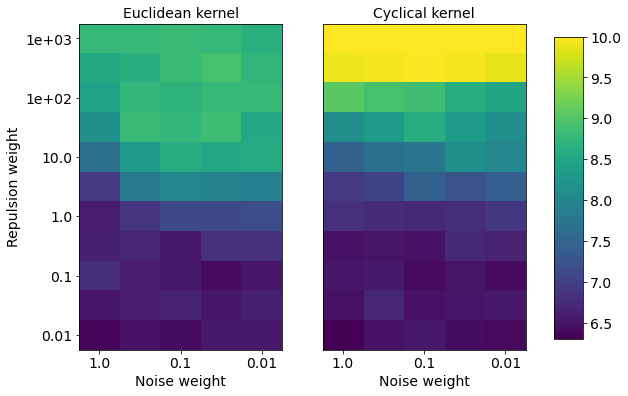

In [123]:
import matplotlib.pyplot as plt
radial_values_reversed = list(reversed([list(reversed(v)) for v in radial_values]))

plt.rcParams["figure.figsize"] = (8,6)
fig, ax = plt.subplots(1, 2)

# Add colorbar
im = ax[1].imshow(radial_values_reversed, vmin=6.3, vmax=10, aspect='auto')
ax[1].set_xlabel("Noise weight", fontsize=14)
ax[1].set_xticks(np.arange(0, len(possible_noise), 2), labels = [f'{s:.3}' for s in list(reversed(possible_noise[::2]))], fontsize=14)
ax[1].set_yticks([])
ax[1].set_title("Cyclical kernel", fontsize=14)

values_reversed = list(reversed([list(reversed(v)) for v in values]))
im = ax[0].imshow(values_reversed, vmin=6.3, vmax=10, aspect='auto')
ax[0].set_xticks(np.arange(0, len(possible_noise), 2), labels = [f'{s:.3}' for s in list(reversed(possible_noise[::2]))], fontsize=14)
ax[0].set_yticks(np.arange(0, len(possible_kernel), 2), labels=[f'{s:.3}' for s in list(reversed(possible_kernel[::2]))], fontsize=14)
ax[0].set_ylabel("Repulsion weight", fontsize=14)
ax[0].set_xlabel("Noise weight", fontsize=14)
ax[0].set_title("Euclidean kernel", fontsize=14)

#ax[0].add_patch(plt.Circle((0.02, 10.04), radius=0.15, color='red'))

cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(14)
plt.savefig('2d_efficiency.png')
plt.show()
